[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/baptiste-pasquier/data_2A/blob/main/model-NN.ipynb)

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import display
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
t = time.time()

# 1. Chargement de la base Sentiment140 préprocessée 

In [5]:
NB_DATA = 100000

In [6]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA, random_state=1234)

In [7]:
df.head(10)

,sentiment,id,date,query_string,user,text
599410,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [8]:
df['target'] = np.where(df['sentiment'] == 'Positive', 1, 0)
df = df[['text', 'target']]
df

,text,target
599410,open itunes will not open naooo the silence is...,0
549856,the sun is already gone for the day,0
1363048,hiya this is my st tweet i am so tired though ...,1
558776,i have the bac today at p m i do not know if i...,0
1582398,as far as i remember you were not half bad ine...,1
...,...,...
1361010,goodmorning tgif,1
520286,is sad last day in brazil back to the us tomor...,0
298908,i need a new computer stat mine is falling apa...,0
929152,these are a few of my favorite things i love t...,1


In [9]:
train_df, test_df = train_test_split(df, test_size=0.2)

a, b = train_df.copy(), test_df.copy()
X_train_text, y_train = a['text'].tolist(), np.asarray(a['target'])
X_test_text, y_test = b['text'].tolist(), np.asarray(b['target'])

In [10]:
print(len(X_train_text), 'train examples')
print(len(X_test_text), 'validation examples')

80000 train examples
20000 validation examples


# 2. Count Vectorizer

In [11]:
vectorizer = CountVectorizer(max_features=3000)
vectorizer.fit(X_train_text + X_test_text)

X_train = vectorizer.transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

In [12]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
input_dim = X_train.shape[1]  # Number of features


def gen_model_Count():
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [14]:
def show(gen_model):
    model = gen_model()
    display(model.summary())
    display(tf.keras.utils.plot_model(model,
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 30,021
Trainable params: 30,021
Non-trainable params: 0
_________________________________________________________________


None

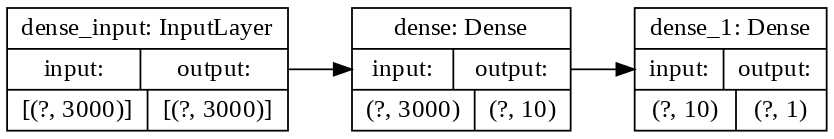

In [15]:
show(gen_model_Count)

In [16]:
model = gen_model_Count()
history = model.fit(X_train, y_train,
                    epochs=25,
                    verbose=2,
                    validation_split=0.2,
                    batch_size=3000)

Epoch 1/25
22/22 - 1s - loss: 0.6830 - accuracy: 0.5899 - val_loss: 0.6653 - val_accuracy: 0.6748
Epoch 2/25
22/22 - 1s - loss: 0.6461 - accuracy: 0.7059 - val_loss: 0.6263 - val_accuracy: 0.7301
Epoch 3/25
22/22 - 1s - loss: 0.6075 - accuracy: 0.7494 - val_loss: 0.5933 - val_accuracy: 0.7492
Epoch 4/25
22/22 - 1s - loss: 0.5757 - accuracy: 0.7626 - val_loss: 0.5675 - val_accuracy: 0.7591
Epoch 5/25
22/22 - 1s - loss: 0.5503 - accuracy: 0.7713 - val_loss: 0.5475 - val_accuracy: 0.7648
Epoch 6/25
22/22 - 1s - loss: 0.5306 - accuracy: 0.7776 - val_loss: 0.5322 - val_accuracy: 0.7676
Epoch 7/25
22/22 - 1s - loss: 0.5151 - accuracy: 0.7823 - val_loss: 0.5203 - val_accuracy: 0.7708
Epoch 8/25
22/22 - 1s - loss: 0.5028 - accuracy: 0.7856 - val_loss: 0.5118 - val_accuracy: 0.7728
Epoch 9/25
22/22 - 1s - loss: 0.4932 - accuracy: 0.7887 - val_loss: 0.5051 - val_accuracy: 0.7743
Epoch 10/25
22/22 - 1s - loss: 0.4856 - accuracy: 0.7902 - val_loss: 0.5002 - val_accuracy: 0.7744
Epoch 11/25
22/22 -

In [17]:
def stat(model, X_train, y_train, X_test, y_test):
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print(f"Training accuracy: {accuracy:.4f}, training loss: {loss:.4f}")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print(f"Testing accuracy:  {accuracy:.4f}, test loss:     {loss:.4f}")

In [18]:
stat(model, X_train, y_train, X_test, y_test)

Training accuracy: 0.7964, training loss: 0.4587
Testing accuracy:  0.7701, test loss:     0.4958


In [19]:
def plot_history(history, model, X_train, y_train, X_test, y_test):
    stat(model, X_train, y_train, X_test, y_test)
    pd.DataFrame(history.history).plot(figsize=(10, 10))
    plt.xlabel("Number of epochs")
    plt.grid(True)
    plt.show()

Training accuracy: 0.7964, training loss: 0.4587
Testing accuracy:  0.7701, test loss:     0.4958


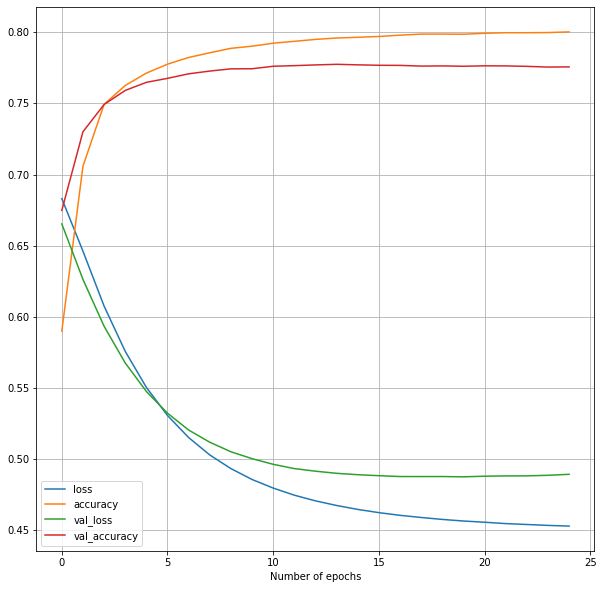

In [20]:
plot_history(history, model, X_train, y_train, X_test, y_test)

In [21]:
def plot_history_v2(history, model, X_train, y_train, X_test, y_test):
    stat(model, X_train, y_train, X_test, y_test)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].plot(x, acc, 'b', label='Training acc')
    ax[0].plot(x, val_acc, 'r', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel("Number of epochs")
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(x, loss, 'b', label='Training loss')
    ax[1].plot(x, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel("Number of epochs")
    ax[1].grid()
    ax[1].legend()

    plt.show()

Training accuracy: 0.7964, training loss: 0.4587
Testing accuracy:  0.7701, test loss:     0.4958


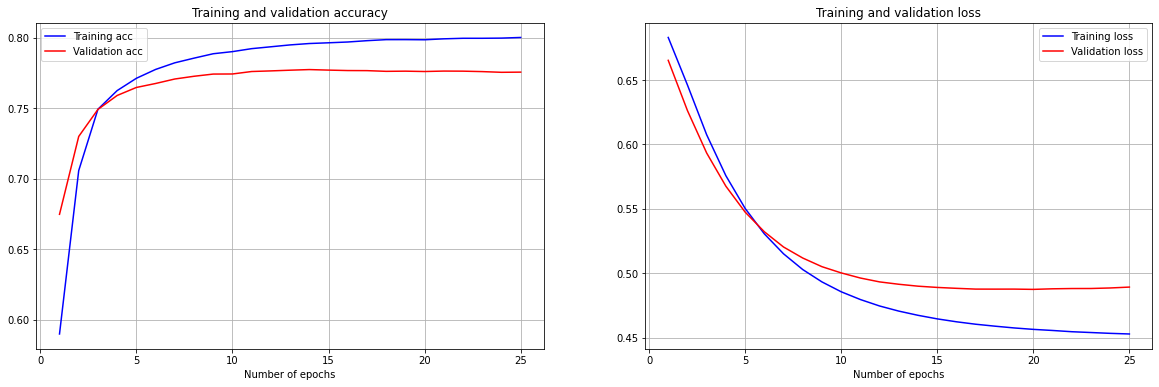

In [22]:
plot_history_v2(history, model, X_train, y_train, X_test, y_test)

# 3. Glove

In [23]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train_text)

X_train = tokenizer.texts_to_sequences(X_train_text)
X_test = tokenizer.texts_to_sequences(X_test_text)

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [24]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [25]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix('data/glove.6B/glove.6B.300d.txt',
                                           tokenizer.word_index,
                                           embedding_dim)
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       [-0.25756001, -0.057132  , -0.67189997, ..., -0.16043   ,
         0.046744  , -0.070621  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.073056  ,  0.025206  ,  0.17371   , ...,  0.52437001,
        -0.040342  , -0.0124    ]])

In [26]:
# Pourcentage des mots représentés dans la matrice
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6634986042802073

In [27]:
def gen_model_Glove():
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                30010     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 30,021
Trainable params: 30,021
Non-trainable params: 0
_________________________________________________________________


None

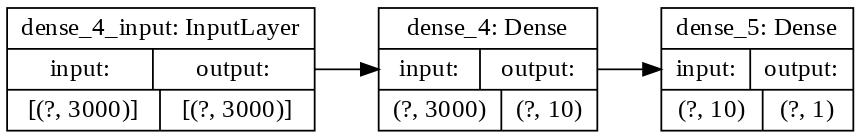

In [28]:
show(gen_model_Count)

Epoch 1/25
22/22 [==============================] - 9s 395ms/step - loss: 0.6673 - accuracy: 0.6158 - val_loss: 0.6096 - val_accuracy: 0.6992
Epoch 2/25
22/22 [==============================] - 8s 378ms/step - loss: 0.5664 - accuracy: 0.7204 - val_loss: 0.5254 - val_accuracy: 0.7462
Epoch 3/25
22/22 [==============================] - 8s 373ms/step - loss: 0.4967 - accuracy: 0.7632 - val_loss: 0.4840 - val_accuracy: 0.7685
Epoch 4/25
22/22 [==============================] - 8s 378ms/step - loss: 0.4582 - accuracy: 0.7871 - val_loss: 0.4667 - val_accuracy: 0.7787
Epoch 5/25
22/22 [==============================] - 8s 372ms/step - loss: 0.4326 - accuracy: 0.8023 - val_loss: 0.4588 - val_accuracy: 0.7829
Epoch 6/25
22/22 [==============================] - 8s 374ms/step - loss: 0.4108 - accuracy: 0.8143 - val_loss: 0.4590 - val_accuracy: 0.7844
Epoch 7/25
22/22 [==============================] - 8s 374ms/step - loss: 0.3907 - accuracy: 0.8261 - val_loss: 0.4514 - val_accuracy: 0.7896
Epoch 

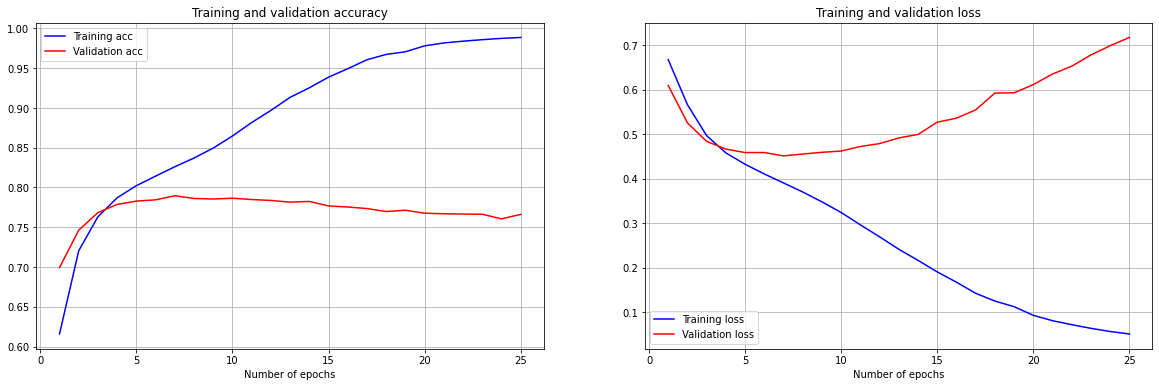

In [29]:
model = gen_model_Glove()
history = model.fit(X_train, y_train,
                    epochs=25,
                    validation_split=0.2,
                    batch_size=3000)
plot_history_v2(history, model, X_train, y_train, X_test, y_test)

Epoch 1/10
27/27 [==============================] - 11s 391ms/step - loss: 0.6051 - accuracy: 0.6686 - val_loss: 0.5250 - val_accuracy: 0.7421
Epoch 2/10
27/27 [==============================] - 10s 376ms/step - loss: 0.4900 - accuracy: 0.7645 - val_loss: 0.4802 - val_accuracy: 0.7694
Epoch 3/10
27/27 [==============================] - 10s 378ms/step - loss: 0.4430 - accuracy: 0.7954 - val_loss: 0.4606 - val_accuracy: 0.7810
Epoch 4/10
27/27 [==============================] - 10s 376ms/step - loss: 0.4115 - accuracy: 0.8144 - val_loss: 0.4533 - val_accuracy: 0.7864
Epoch 5/10
27/27 [==============================] - 10s 372ms/step - loss: 0.3866 - accuracy: 0.8295 - val_loss: 0.4543 - val_accuracy: 0.7862
Epoch 6/10
27/27 [==============================] - 10s 375ms/step - loss: 0.3619 - accuracy: 0.8431 - val_loss: 0.4507 - val_accuracy: 0.7900
Epoch 7/10
27/27 [==============================] - 10s 368ms/step - loss: 0.3381 - accuracy: 0.8569 - val_loss: 0.4541 - val_accuracy: 0.7901

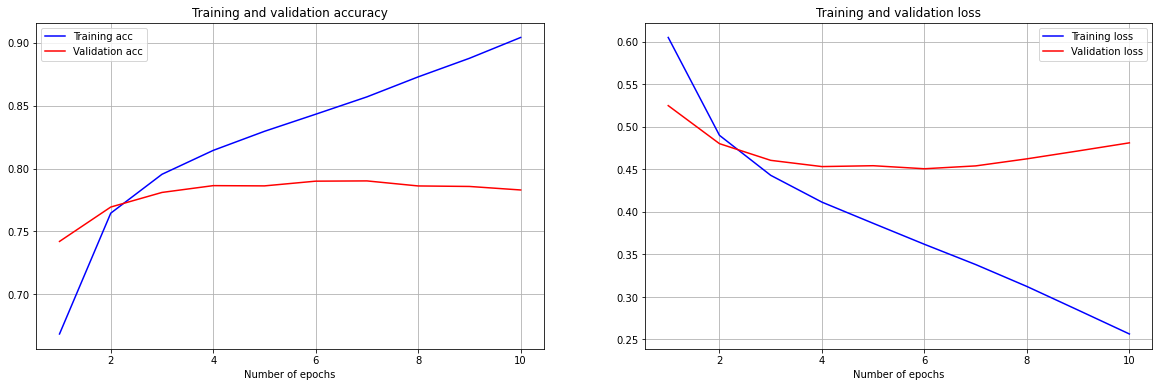

In [30]:
model = gen_model_Glove()
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=3000)
plot_history_v2(history, model, X_train, y_train, X_test, y_test)

# 4. TF Hub

In [31]:
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/" + MODEL + "/" + str(VERSION)
print(URL)

https://tfhub.dev/google/nnlm-en-dim128/2


In [32]:
hub_layer = hub.KerasLayer(URL, input_shape=[],
                           dtype=tf.string, trainable=True)

In [33]:
hub_layer(X_train_text[:2])

<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
array([[ 3.19343656e-01,  7.93849155e-02,  7.96036348e-02,
        -4.27312553e-02,  9.99616161e-02,  1.62934154e-01,
        -1.00117743e-01, -9.48785469e-02,  1.87207535e-01,
        -9.64922272e-03,  8.09925981e-03, -7.71420682e-03,
        -1.21512152e-01, -1.40935898e-01, -1.13067903e-01,
         4.37197685e-02, -1.40529275e-01, -1.68688610e-01,
        -2.58173663e-02,  2.01774657e-01,  7.82175139e-02,
         1.39840186e-01,  9.70373005e-02, -1.13473460e-01,
        -4.53174189e-02, -2.52427131e-01,  1.44942388e-01,
        -1.00843772e-01, -2.93695360e-01,  8.39908171e-05,
         7.77355134e-02,  4.47570793e-02, -6.15927950e-02,
         1.14912838e-01, -1.58097357e-01,  1.98199525e-01,
        -4.78441641e-02, -1.03137366e-01,  1.38753235e-01,
         2.18481988e-01, -1.57286644e-01,  1.98421907e-02,
         1.03818877e-02,  1.69259548e-01, -1.57009363e-01,
         1.80372983e-01,  9.14027840e-02,  9.43011120e-02,
      

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_10 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


None

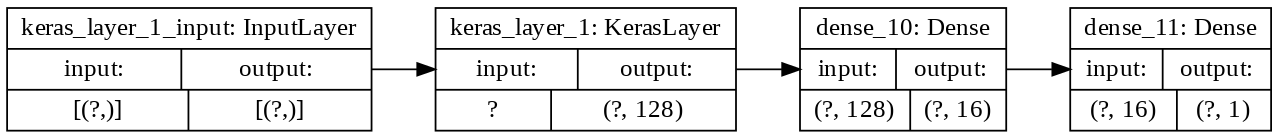

In [34]:
def gen_model_hub():
    hub_layer = hub.KerasLayer(URL, input_shape=[],
                               dtype=tf.string, trainable=True)
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


show(gen_model_hub)

In [35]:
X_train = np.asarray(X_train_text)
X_test = np.asarray(X_test_text)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

Epoch 1/15
43/43 [==============================] - 3s 78ms/step - loss: 0.6403 - accuracy: 0.5342 - val_loss: 0.5660 - val_accuracy: 0.6737
Epoch 2/15
43/43 [==============================] - 3s 75ms/step - loss: 0.4972 - accuracy: 0.7456 - val_loss: 0.4769 - val_accuracy: 0.7657
Epoch 3/15
43/43 [==============================] - 3s 75ms/step - loss: 0.4203 - accuracy: 0.8038 - val_loss: 0.4649 - val_accuracy: 0.7704
Epoch 4/15
43/43 [==============================] - 3s 76ms/step - loss: 0.3815 - accuracy: 0.8283 - val_loss: 0.4728 - val_accuracy: 0.7678
Epoch 5/15
43/43 [==============================] - 3s 76ms/step - loss: 0.3529 - accuracy: 0.8440 - val_loss: 0.4889 - val_accuracy: 0.7634
Epoch 6/15
43/43 [==============================] - 3s 75ms/step - loss: 0.3309 - accuracy: 0.8561 - val_loss: 0.5095 - val_accuracy: 0.7625
Epoch 7/15
43/43 [==============================] - 3s 76ms/step - loss: 0.3131 - accuracy: 0.8645 - val_loss: 0.5333 - val_accuracy: 0.7593
Epoch 8/15
43

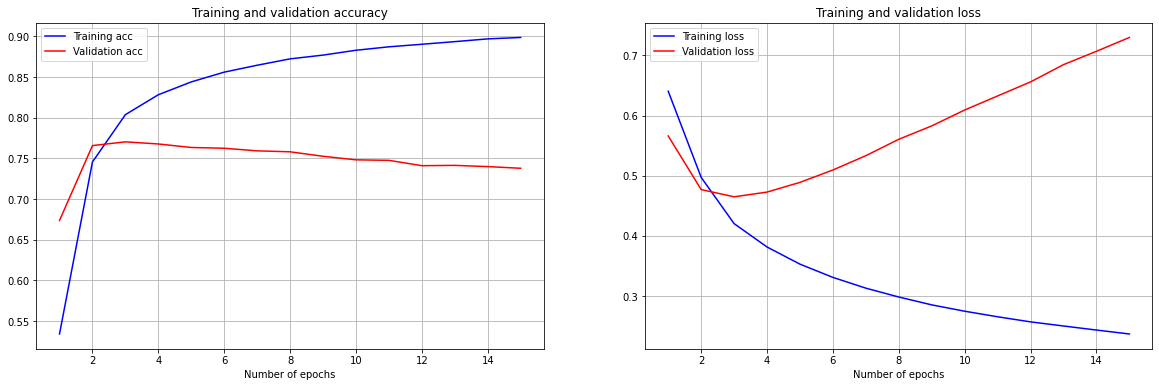

In [36]:
model = gen_model_hub()
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=1500,
                    validation_split=0.2,
                    verbose=1)
plot_history_v2(history, model, X_train, y_train, X_test, y_test)

Epoch 1/15
22/22 [==============================] - 2s 86ms/step - loss: 0.6528 - accuracy: 0.5188 - val_loss: 0.6040 - val_accuracy: 0.6099
Epoch 2/15
22/22 [==============================] - 2s 80ms/step - loss: 0.5536 - accuracy: 0.6871 - val_loss: 0.5234 - val_accuracy: 0.7280
Epoch 3/15
22/22 [==============================] - 2s 80ms/step - loss: 0.4728 - accuracy: 0.7680 - val_loss: 0.4817 - val_accuracy: 0.7582
Epoch 4/15
22/22 [==============================] - 2s 80ms/step - loss: 0.4228 - accuracy: 0.7990 - val_loss: 0.4695 - val_accuracy: 0.7681
Epoch 5/15
22/22 [==============================] - 2s 79ms/step - loss: 0.3896 - accuracy: 0.8227 - val_loss: 0.4691 - val_accuracy: 0.7682
Epoch 6/15
22/22 [==============================] - 2s 78ms/step - loss: 0.3653 - accuracy: 0.8370 - val_loss: 0.4768 - val_accuracy: 0.7693
Epoch 7/15
22/22 [==============================] - 2s 80ms/step - loss: 0.3453 - accuracy: 0.8486 - val_loss: 0.4884 - val_accuracy: 0.7647
Epoch 8/15
22

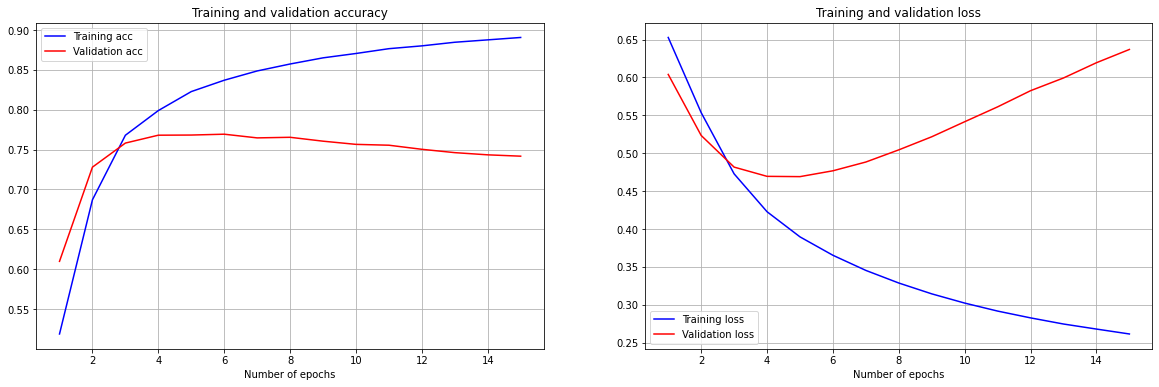

In [37]:
model = gen_model_hub()
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=3000,
                    validation_split=0.2,
                    verbose=1)
plot_history_v2(history, model, X_train, y_train, X_test, y_test)

In [38]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:08:43
